# Block DCT (Discrete Cosine Transform)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import frame
import block_DCT
import YCoCg as YUV
import cv2
import distortion
import os
import pylab

## Testing `block_DCT.block_analyze()` and `block_DCT.block_synthesize()`

In [2]:
#a = np.random.randint(low=0, high=100, size=(4,4,3))
a = np.full(shape=(4,4,3), fill_value=10, dtype=np.int16)

In [3]:
print(a)

[[[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]]


In [4]:
b = block_DCT.block_analyze(a)

In [5]:
print(b.astype(np.int16))

[[[40 40 40]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


In [6]:
c = block_DCT.block_synthesize(b)

In [7]:
print(c.astype(np.int16))

[[[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]]


## Some routines

In [8]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    #return 255*(img-min_component)/max_min_component
    return (img-min_component)/max_min_component

def print_stats(frame):
    for i in range(frame.shape[2]):
        print("component", i, frame[..., i].max(), frame[..., i].min(), frame[..., i].dtype)

def show_RGB_frame(frame, title=''):
    plt.figure(figsize=(16,16))
    plt.title(title, fontsize=20)
    plt.imshow(cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB))
    print_stats(frame)

def show_frame(frame, title=''):
    plt.figure(figsize=(16,16))
    plt.title(title, fontsize=20)
    plt.imshow(frame)
    print_stats(frame)

## Testing `block_DCT.analyze()` and `block_DCT.synthesize()`

frame.read: ../sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
component 0 255 0 uint16
component 1 255 0 uint16
component 2 255 0 uint16


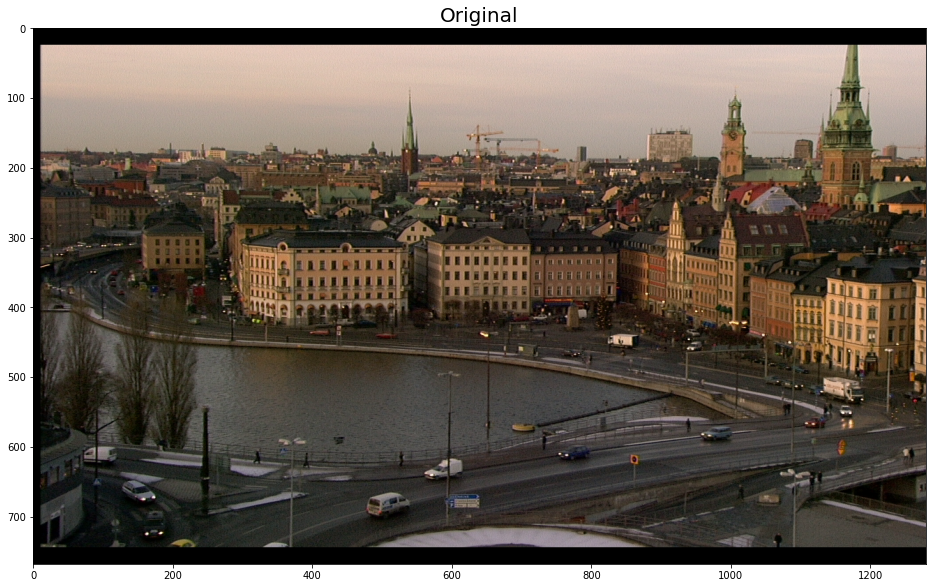

In [9]:
x = frame.read(f"../sequences/stockholm/", 0)
#show_frame(normalize(x))
show_RGB_frame(x, title="Original")

In [10]:
#x = YUV.from_RGB(x.astype(np.int16))
#show_frame(x)

In [11]:
block_y_side = block_x_side = 8

In [12]:
y = block_DCT.analyze(x, block_y_side, block_x_side)

component 0 227.71301 11.400596 float32
component 1 234.66406 7.24156 float32
component 2 255.0 0.0 float32
component 0 220.81473 11.733201 float32
component 1 233.14896 7.4528284 float32
component 2 255.0 0.0 float32


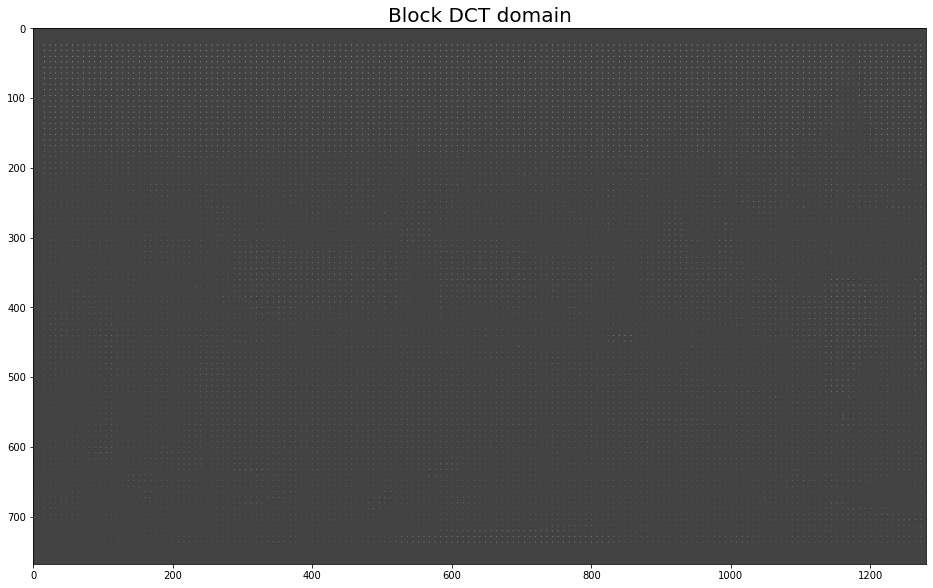

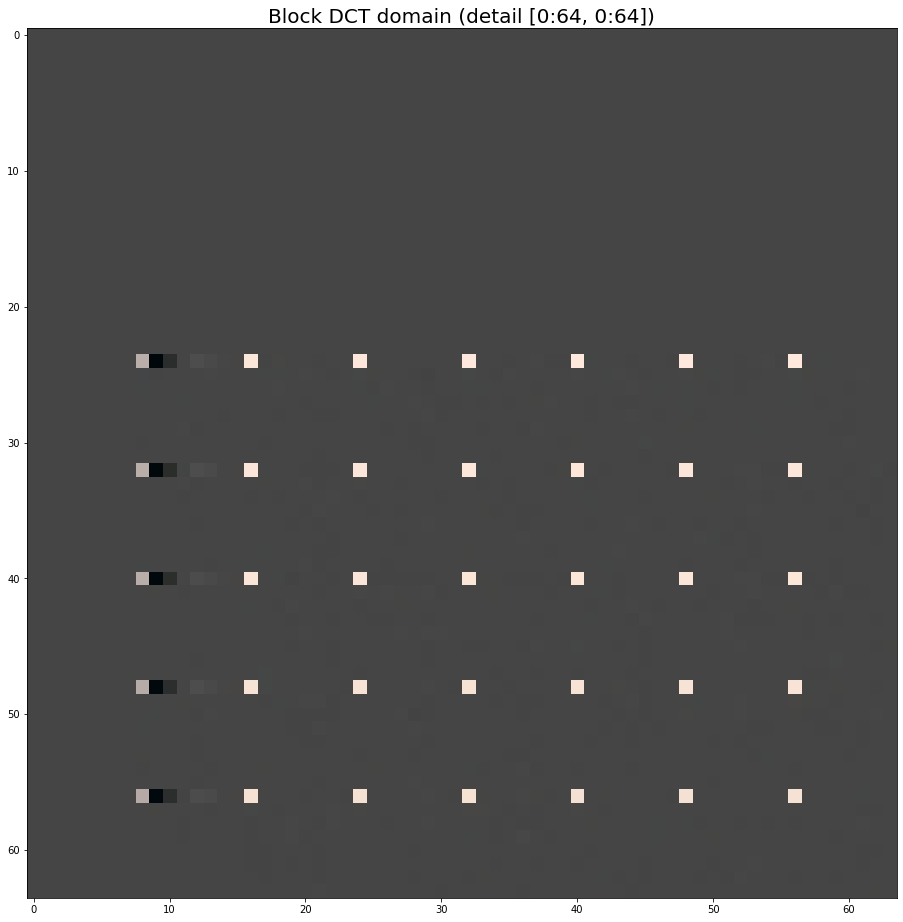

In [13]:
show_RGB_frame(255*normalize(y), "Block DCT domain")
show_RGB_frame(255*normalize(y[:64, :64]), "Block DCT domain (detail [0:64, 0:64])")

In [14]:
z = block_DCT.synthesize(y, block_y_side, block_x_side)

In [15]:
(x-z).max()

1

component 0 255.0 0.0 float64
component 1 255.0 0.0 float64
component 2 255.0 0.0 float64


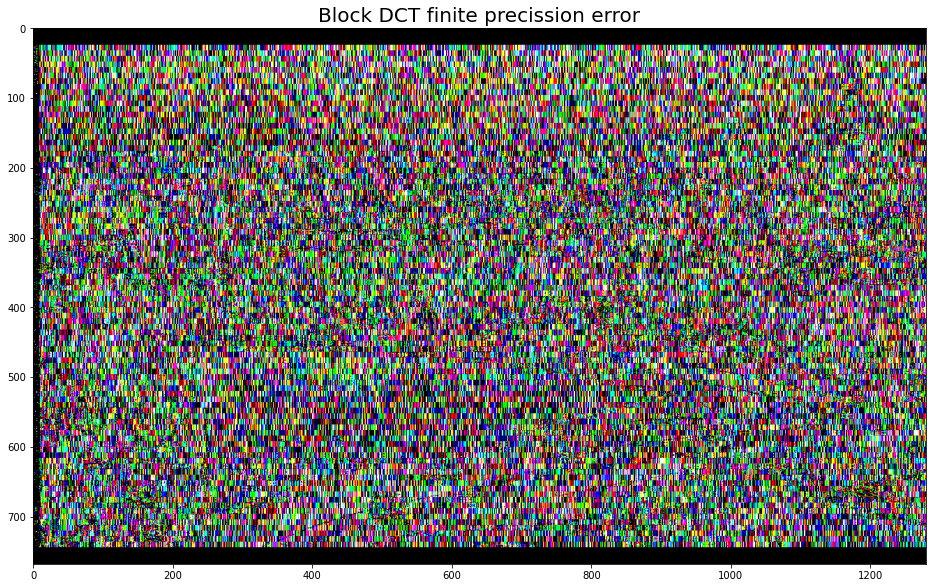

In [16]:
r = x - z
show_RGB_frame(255*normalize(r), "Block DCT finite precission error")

component 0 255 0 int16
component 1 255 0 int16
component 2 255 0 int16


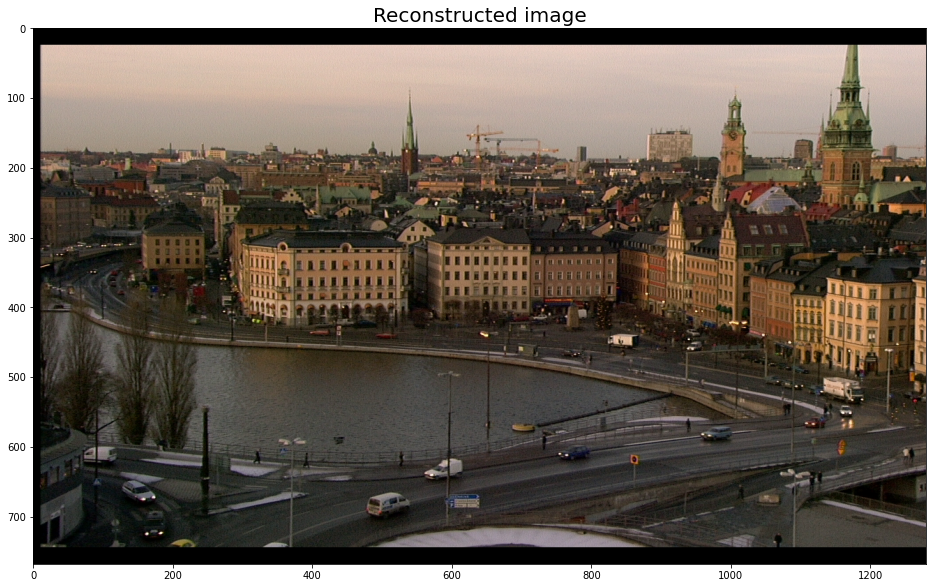

In [17]:
show_RGB_frame(z, "Reconstructed image")

## Testing `block_DCT.constant_quantize()` and `block_DCT.constant_dequantize()`

In [18]:
block_y_side = block_x_side = 64
q_step = 128
y = block_DCT.analyze(x, block_y_side, block_x_side)
q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, 128)
dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, 128)
z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)

component 0 216 0 int16
component 1 220 0 int16
component 2 244 0 int16


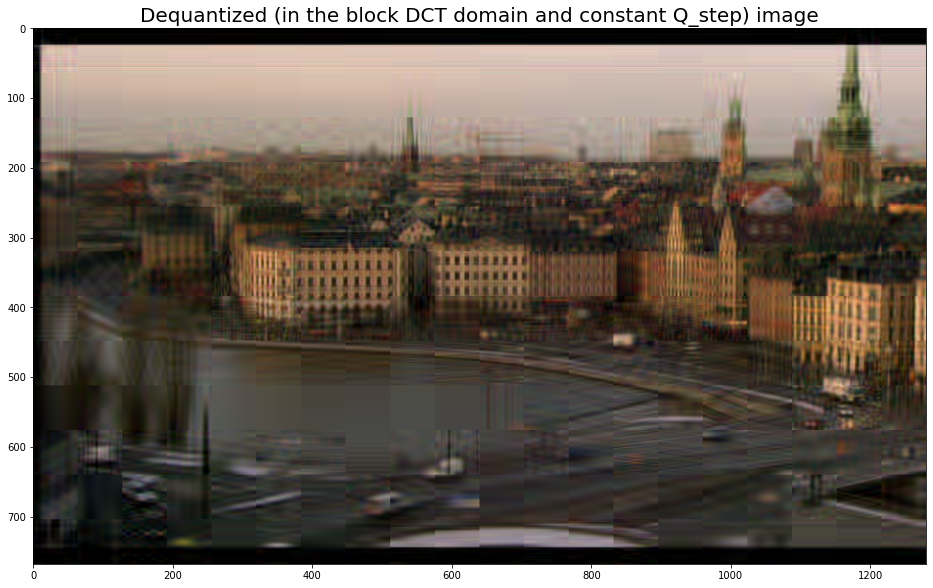

In [19]:
show_RGB_frame(np.clip(z, a_max=255, a_min=0), "Dequantized (in the block DCT domain and constant Q_step) image")

component 0 252.78901734104048 1.4739884393063583 float64
component 1 249.84104046242774 0.0 float64
component 2 255.0 0.0 float64


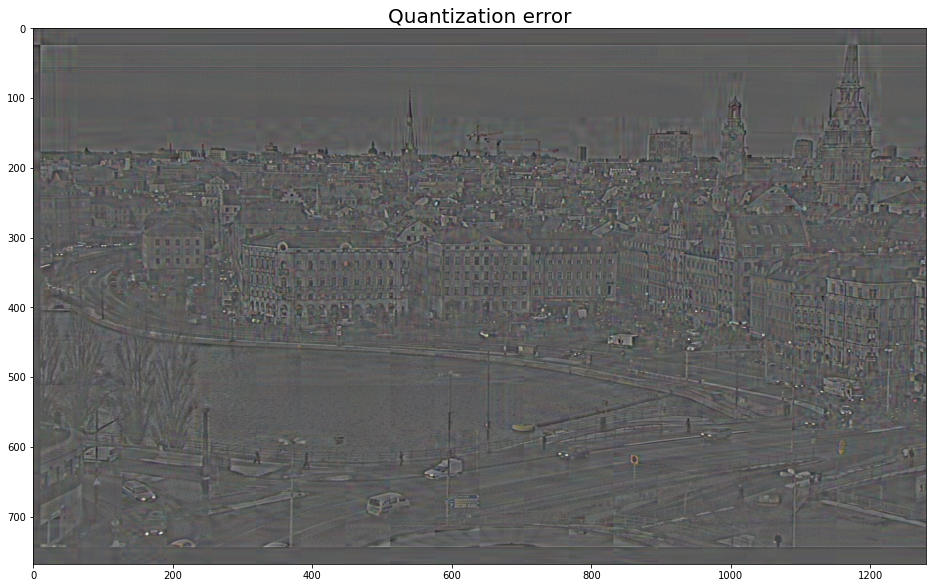

In [20]:
r = x - z
n = normalize(r)
show_RGB_frame(255*n, "Quantization error")

## Testing `block_DCT.find_optimal_Q_steps()`

In [21]:
#block_y_side = block_x_side = 64
#q_step = 128
#y = block_DCT.analyze(x, block_y_side, block_x_side)
slopes, Q_steps = block_DCT.get_slopes(y, block_y_side, block_x_side, q_step)

In [22]:
print(slopes)

[[66.34071822 25.3607379  25.87406026 26.8548175  27.14430096 27.23868328
  26.78654351 26.79286393 26.91506384 27.45035713 26.05012253 26.84492392
  26.73313669 26.15460593 26.04028586 27.03092137 25.44065228 25.91262831
  56.97420611 27.6686986 ]
 [19.52956687  4.69043902  4.6125812   4.23093901  4.69875354  4.84613635
   4.6664882   5.08767168 26.0422274   4.799859    4.74159187  4.61862741
   4.60883265  4.69718129  4.75746915 39.20406787  3.9675336  22.85813536
  71.49493495  4.39194924]
 [37.06344228 30.62487735 31.72792    56.75999048 43.54546551 39.98804651
  47.18657366 49.56184142 59.1635064  61.94505536 50.7714955  34.45438783
  35.91738265 44.91235362 52.50004122 64.76246952 32.27435198 62.60650214
  76.59490623 38.31333102]
 [48.98645677 48.15009876 64.50279218 62.54652031 61.43292338 67.89716129
  72.53815749 73.36273133 74.05524581 87.07388689 82.02973984 94.33171014
  95.50850622 97.4024456  69.74226261 76.55458734 58.42300654 73.59220274
  66.07407693 71.21718922]
 [31

In [23]:
Q_steps, new_slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_steps, slopes, np.median(slopes))

0/11 1/11 2/11 3/11 4/11 5/11 6/11 7/11 8/11 9/11 10/11 11/11 

In [24]:
print(Q_steps, new_slopes)

[[  95  164  163  165  166  164  164  161  168  163  160  161  165  161
   165  159  161  162  106  164]
 [ 256  747  708  715  767  771  733  768  452  694  656  652  859  853
   856  149  810  539   77  813]
 [ 155  267  218   99  132  162  116  108   89   78   97  180  159  126
    96   77  251   79   71  156]
 [ 103  113   82   76   83   71   68   68   66   58   59   56   56   54
    65   66   83   66   72   77]
 [ 269   75  128  213   74   72   70   70   59   64   78   84   63   72
    71   95  108  104   94   82]
 [  68  151  112  129   60   62  108  115  103   97  101   85   96  116
    72   79   99   76   75   77]
 [ 121  134  268  144   64   62   65   96  115  190   74   68   77   79
    59   66  108   61   61   89]
 [ 181  229  147  180  286  241  276  267  187  156  101  135   87   77
    76  201   81   67   56   69]
 [ 472  128  339  153  931 1081 1124 1143  992  939  468  434  164  100
   100   92  133   60   57   87]
 [ 258   74  110  115  114  108  154  535  152   87  58

In [25]:
q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)

component 0 211 0 int16
component 1 223 0 int16
component 2 255 0 int16


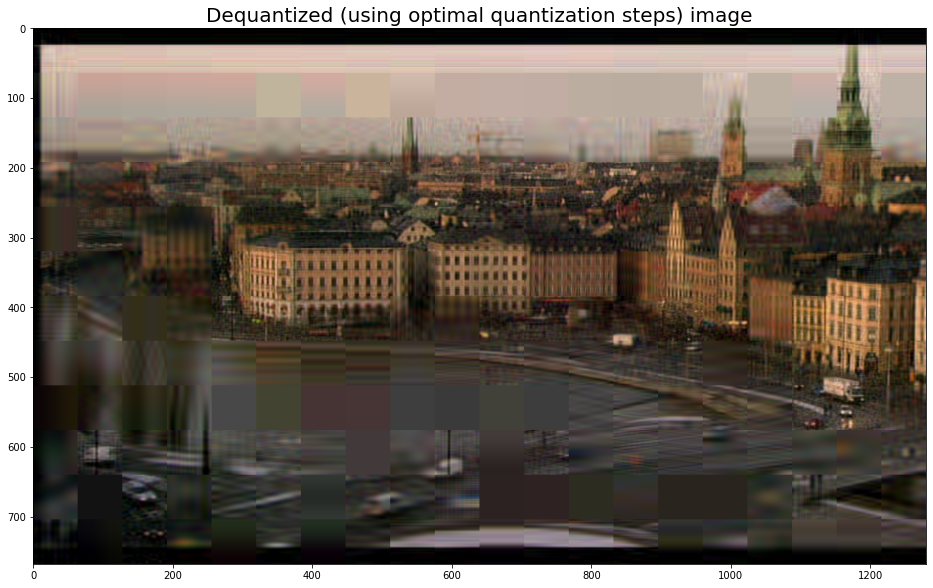

In [26]:
show_RGB_frame(np.clip(z, a_max=255, a_min=0), "Dequantized (using optimal quantization steps) image")

## Computing the variance of the DCT coefficients

In [27]:
block_y_side = block_x_side = 64
y = block_DCT.analyze(x, block_y_side, block_x_side)
q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, 128)
v = block_DCT.compute_variances(q_y, block_y_side, block_x_side)

In [28]:
print(v)

[[5.30234252e+02 1.34020660e+01 8.60722222e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.67130895e+02 3.88024691e+00 1.48387153e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.53443499e+01 1.83487654e+00 7.51572145e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.49305556e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


## Switching between blocks and subbands

In [29]:
block_y_side = block_x_side = 8
Q_step = 32
x = frame.read(f"../sequences/stockholm/", 0)
y = block_DCT.analyze(x, block_y_side, block_x_side)
q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, Q_step)
cor_dq_y = block_DCT.create_subbands(dq_y, block_y_side, block_x_side)

frame.read: ../sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 


component 0 1568 -544 int16
component 1 1632 -576 int16
component 2 1856 -640 int16
component 0 225.57692307692307 9.807692307692308 float64
component 1 232.1153846153846 6.538461538461538 float64
component 2 255.0 0.0 float64
component 0 215.43103448275863 0.0 float64
component 1 224.22413793103448 0.0 float64
component 2 255.0 0.0 float64


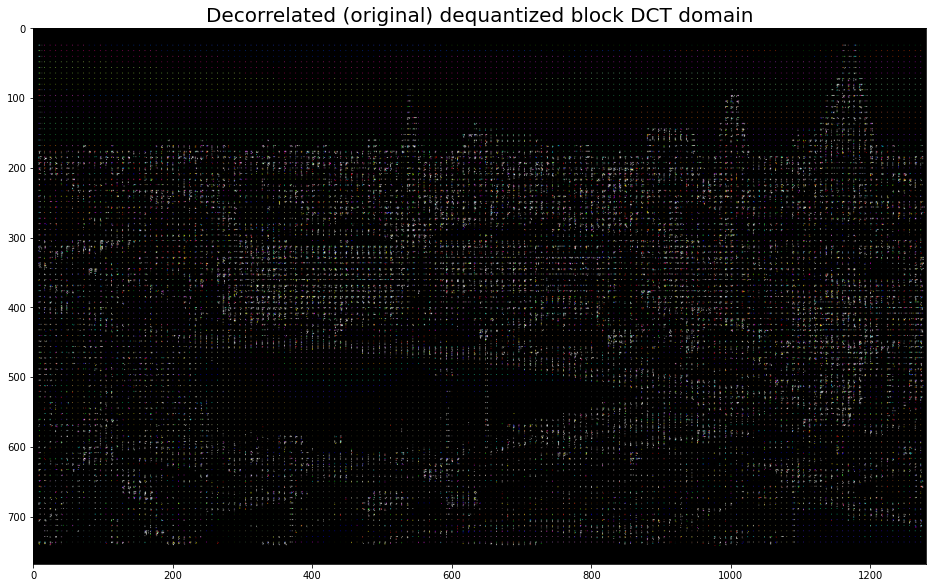

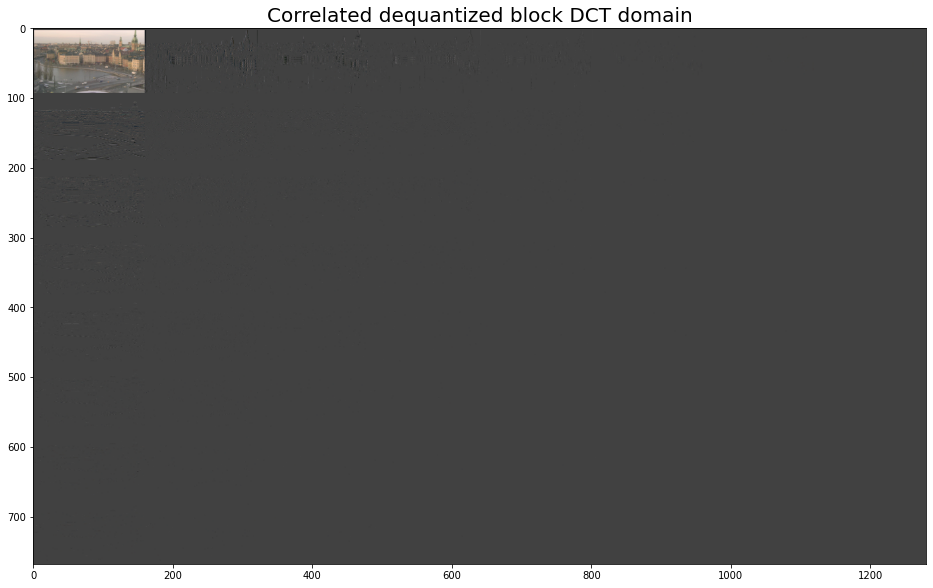

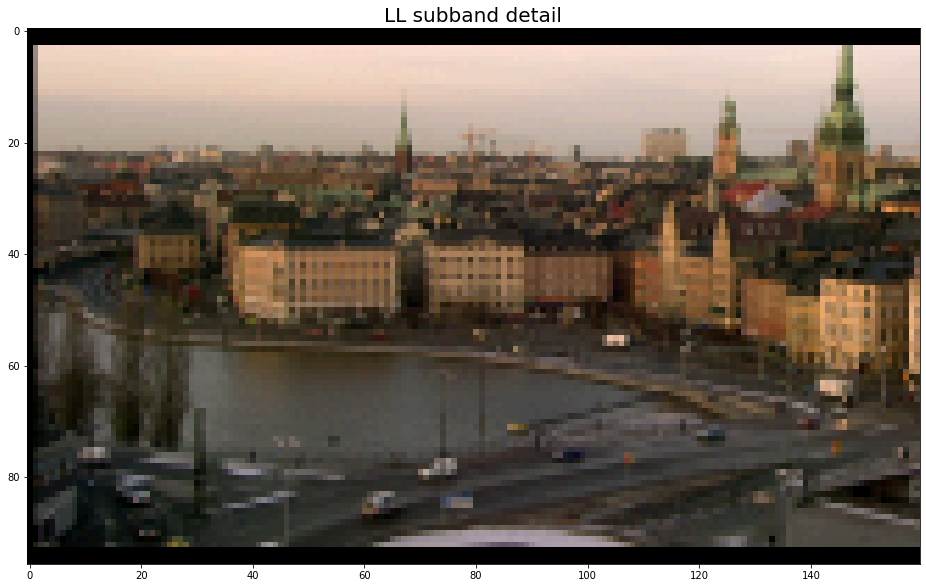

In [30]:
show_RGB_frame(dq_y, "Decorrelated (original) dequantized block DCT domain")
show_RGB_frame(255*normalize(cor_dq_y), "Correlated dequantized block DCT domain")
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_frame(255*normalize(cor_dq_y[:blocks_in_y, :blocks_in_x]), "LL subband detail")

In [31]:
decor_dq_y = block_DCT.create_blocks(cor_dq_y, block_y_side, block_x_side)

component 0 1568 -544 int16
component 1 1632 -576 int16
component 2 1856 -640 int16


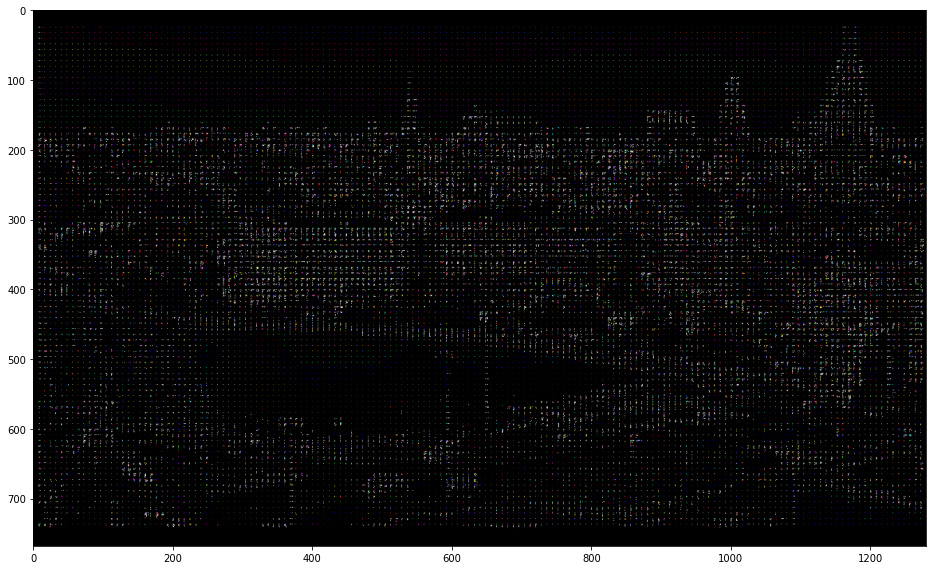

In [32]:
show_RGB_frame(decor_dq_y)

In [33]:
(decor_dq_y == dq_y).all()

True

## Quantizing the YCoCg/B-DCT domain

### Using constant quantization

In [34]:
xx = frame.read(f"../sequences/stockholm/", 0)
x = YUV.from_RGB(xx.astype(np.int16))

disperse_RD_points = []
subband_RD_points = []
block_y_side = block_x_side = 8
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
    dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, Q_step)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    frame.write(q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    disperse_RD_points.append((bits_per_pixel, MSE))
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    frame.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    subband_RD_points.append((bits_per_pixel, MSE))
    print(Q_step, end=' ', flush=True)

frame.read: ../sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
frame.write: /tmp/128_000.png (768, 1280, 3) int16 46727 
frame.write: /tmp/128_000.png (768, 1280, 3) int16 14533 
128 frame.write: /tmp/64_000.png (768, 1280, 3) int16 63657 
frame.write: /tmp/64_000.png (768, 1280, 3) int16 26762 
64 frame.write: /tmp/32_000.png (768, 1280, 3) int16 97077 
frame.write: /tmp/32_000.png (768, 1280, 3) int16 54084 
32 frame.write: /tmp/16_000.png (768, 1280, 3) int16 160121 
frame.write: /tmp/16_000.png (768, 1280, 3) int16 107326 
16 frame.write: /tmp/8_000.png (768, 1280, 3) int16 292638 
frame.write: /tmp/8_000.png (768, 1280, 3) int16 224252 
8 frame.write: /tmp/4_000.png (768, 1280, 3) int16 490747 
frame.write: /tmp/4_000.png (768, 1280, 3) int16 416172 
4 frame.write: /tmp/2_000.png (768, 1280, 3) int16 696755 
frame.write: /tmp/2_000.png (768, 1280, 3) int16 631278 
2 frame.write: /tmp/1_000.png (768, 1280, 3) int16 906394 
frame.write: /tmp/1_000.png (768, 1280, 3) int16 

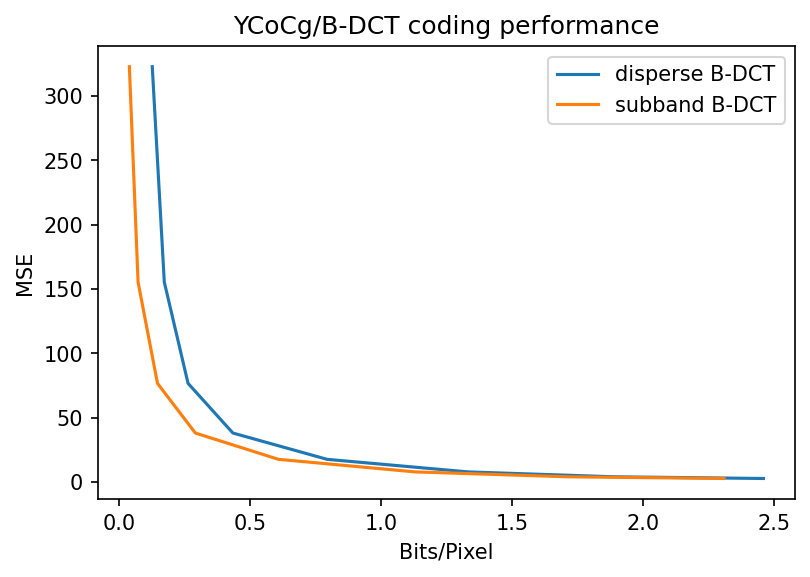

In [35]:
pylab.figure(dpi=150)
pylab.plot(*zip(*disperse_RD_points), label="disperse B-DCT")
pylab.plot(*zip(*subband_RD_points), label="subband B-DCT")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

### Using "optimal" quantization

In [36]:
xx = frame.read(f"../sequences/stockholm/", 0)
x = YUV.from_RGB(xx.astype(np.int16))

constant_RD_points = []
optimal_RD_points = []
block_y_side = block_x_side = 128
for Q_step in [128,64,32,16,8,4,2,1]:
    print(Q_step, end=' ', flush=True)
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    
    # Constant quantization
    q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
    dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, Q_step)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    frame.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    constant_RD_points.append((bits_per_pixel, MSE))

    # Optimal quantization
    slopes, Q_steps = block_DCT.get_slopes(y, block_y_side, block_x_side, Q_step)
    target_slope = np.median(slopes)
    Q_steps, new_slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_steps, slopes, target_slope)
    print(f"current={slopes.astype(np.int16)}\ntarget_slope={target_slope}\nnew={new_slopes.astype(np.int16)}\nQ_steps={Q_steps}")
    print(slopes.max(), slopes.min())
    print(new_slopes.max(), new_slopes.min())
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    frame.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    optimal_RD_points.append((bits_per_pixel, MSE))

frame.read: ../sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
128 frame.write: /tmp/128_000.png (768, 1280, 3) int16 11115 
0/5 1/5 2/5 3/5 4/5 5/5 current=[[25 10 10 11 14 10 10 19 12 29]
 [27 36 34 37 44 42 46 44 39 41]
 [31 26 46 39 44 36 41 42 36 42]
 [25 22 38 29 25 37 36 41 42 48]
 [27 26 21 14 25 25 27 32 35 39]
 [18 30 22 19 28 16 24 17 26 20]]
target_slope=28.851547163991025
new=[[29 28 28 29 28 29 29 29 29 28]
 [28 29 28 28 28 29 29 29 29 29]
 [28 29 29 28 29 28 29 28 28 28]
 [28 28 29 28 28 29 29 28 28 29]
 [28 29 28 30 29 28 29 29 28 28]
 [29 29 29 28 28 29 29 28 29 28]]
Q_steps=[[ 138  233  235  229  216  233  237  195  228  124]
 [ 140   92   96   81   71   74   71   75   84   82]
 [ 110  143   72   85   74   86   78   79   92   82]
 [ 163  219   90  124  160   87   88   77   76   68]
 [ 132  156  247 1091  191  197  142  104   94   82]
 [ 269  109  184  212  139  271  180  345  154  224]]
48.58315980607916 10.64840020797946
30.77751873735558 28.861938852750615

<ipython-input-36-cc18688e5359>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(f"current={slopes.astype(np.int)}\ntarget_slope={target_slope}\nnew={new_slopes.astype(np.int)}\nQ_steps={Q_steps}")


frame.write: /tmp/64_000.png (768, 1280, 3) int16 24480 
0/5 1/5 2/5 3/5 4/5 5/5 current=[[11  4  4  4  7  4  4  9  7 16]
 [17 21 21 23 26 25 27 25 22 23]
 [21 17 26 22 25 22 24 23 21 23]
 [16 15 22 19 15 22 23 24 24 27]
 [17 16 14 10 16 17 17 19 21 23]
 [11 18 14 12 16 10 13 12 15 12]]
target_slope=17.65600247637383
new=[[17 18 17 18 17 18 17 17 17 17]
 [17 17 17 17 17 18 17 18 17 17]
 [17 17 17 17 17 17 17 17 17 17]
 [17 17 18 18 17 17 17 17 17 17]
 [17 17 17 17 17 17 17 17 17 17]
 [17 18 17 17 17 17 17 17 18 17]]
Q_steps=[[ 91 159 173 170 151 173 168 122 158  70]
 [ 66  50  51  46  42  42  42  46  46  48]
 [ 49  68  43  51  44  48  45  47  51  48]
 [ 70  79  49  57  77  49  46  45  45  42]
 [ 63  75  93 223  77  65  66  57  51  47]
 [125  60  86 103  69 149  93 128  77 105]]
27.635540295738895 4.627980321117262
18.339271314157017 17.656095990969014
frame.write: /tmp/64_000.png (768, 1280, 3) int16 32085 
32 frame.write: /tmp/32_000.png (768, 1280, 3) int16 56846 
0/5 1/5 2/5 3/5 4/5

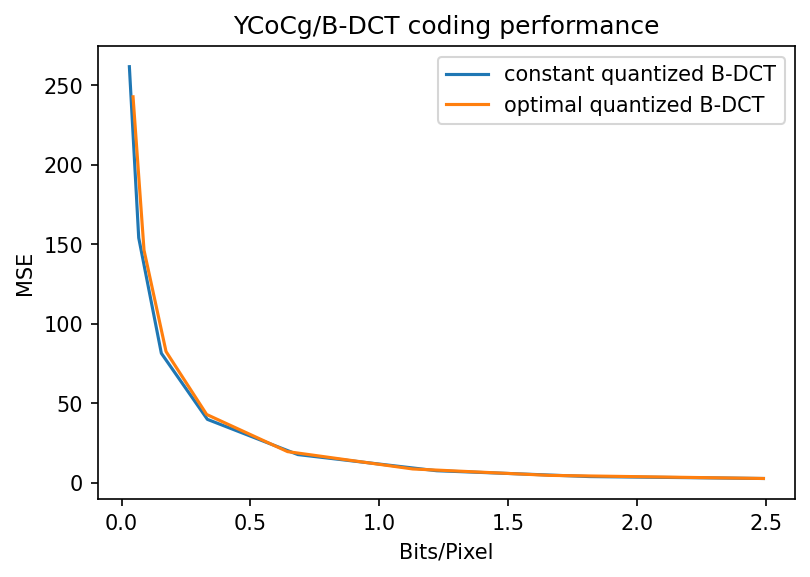

In [37]:
pylab.figure(dpi=150)
pylab.plot(*zip(*constant_RD_points), label="constant quantized B-DCT")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantized B-DCT")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [38]:
Q_steps

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint64)

In [39]:
slopes

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [40]:
new_slopes

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])